In [1]:
import pandas as pd
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras import layers, regularizers, Sequential, optimizers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tensorflow.keras import layers, regularizers, Sequential, optimizers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
df = pd.read_csv('Dataset/umist_faces.csv')


In [3]:
df.shape

(575, 10305)

In [4]:
df.head()

label  pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  \
0    1a    233.0    234.0    234.0    233.0    234.0    232.0    232.0   
1    1a    234.0    234.0    234.0    234.0    233.0    232.0    202.0   
2    1a    234.0    234.0    234.0    234.0    233.0    230.0    225.0   
3    1a    234.0    234.0    234.0    234.0    234.0    234.0    234.0   
4    1a    234.0    234.0    234.0    234.0    234.0    234.0    234.0   

   pixel_7  pixel_8  ...  pixel_10294  pixel_10295  pixel_10296  pixel_10297  \
0    168.0     99.0  ...        157.0        154.0        151.0        147.0   
1     98.0     79.0  ...        158.0        154.0        150.0        147.0   
2    109.0     85.0  ...        180.0        174.0        168.0        164.0   
3    232.0    229.0  ...        174.0        168.0        162.0        157.0   
4    234.0    229.0  ...        186.0        176.0        170.0        164.0   

   pixel_10298  pixel_10299  pixel_10300  pixel_10301  pixel_10302  \
0        143.0        140.0        141.0        141.0        140.0   
1        141.0        140.0        137.0        138.0        137.0   
2        157.0        152.0        151.0        148.0        145.0   
3        155.0        150.0        144.0        144.0        142.0   
4        162.0        157.0        152.0        150.0        148.0   

   pixel_10303  
0        136.0  
1        137.0  
2        145.0  
3        143.0  
4        148.0  

[5 rows x 10305 columns]

In [5]:
# df.duplicated()
# Custom funciton to check for duplicates
counter = 0
# If the vaues are duplicated then the label is also gonna be same
for i in range(len(df)):
    for j in range(i+1, len(df)):
        # Check for the same image if the labels are same
        if(df.iloc[i, 0] == df.iloc[j, 0]):
            # Check if the rows are same
            if(df.iloc[i, 1:].equals(df.iloc[j, 1:])):
                print("Duplicate found")
                print(df.iloc[i, 0])
                print(df.iloc[j, 0])
                print("Row 1: ", df.iloc[i, 1:])
                print("Row 2: ", df.iloc[j, 1:])
                counter += 1
                print("\n\n")
                
print("Total duplicates found: ", counter)
        

In [6]:
# Dropping the duplicates
df = df.drop_duplicates()
df.shape

(565, 10305)

In [7]:
X = df.drop('label', axis=1).values
y = df['label']

In [8]:
# Check if there are any duplicates
df.duplicated().sum()


0

In [9]:
# Reshape images (assuming 112x92 image size)
image_size = (112, 92)
X = X.reshape(-1, *image_size)

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)


In [11]:
from sklearn.model_selection import train_test_split
# Split data into training, testing, and validation sets using stratified sampling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

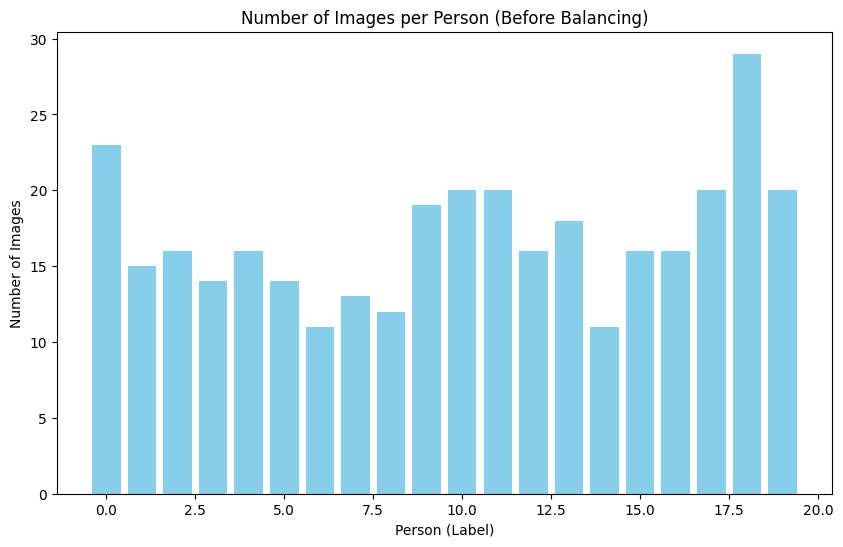

Balanced dataset shape: (960, 112, 92, 1), (960,)


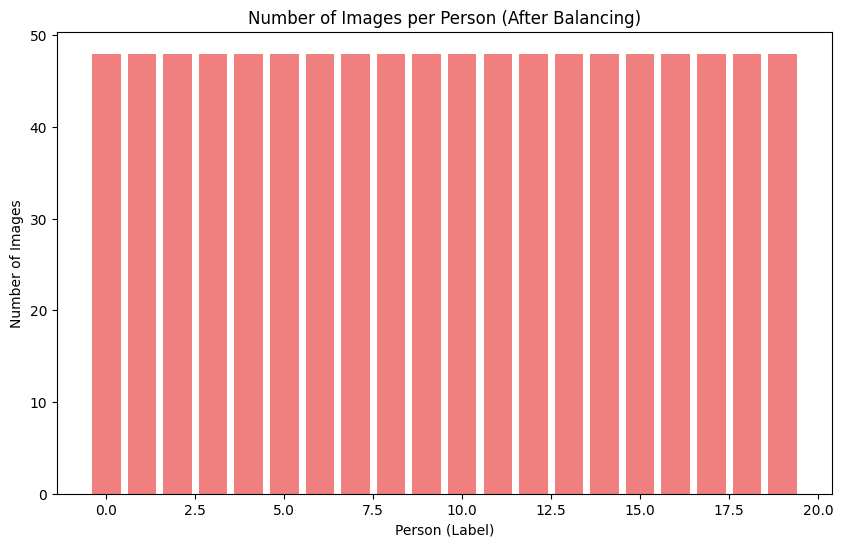

In [12]:
# Balance the training dataset using ImageDataGenerator
TARGET_IMAGES_PER_PERSON = 48

# Split the dataset by label
unique_labels = np.unique(y_train)
label_to_images = {label: X_train[y_train == label] for label in unique_labels}

# Create an ImageDataGenerator instance for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Before balancing: plot the number of images per person
initial_counts = [np.sum(y_train == label) for label in unique_labels]
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, initial_counts, color='skyblue')
plt.title('Number of Images per Person (Before Balancing)')
plt.xlabel('Person (Label)')
plt.ylabel('Number of Images')
plt.show()

balanced_X = []
balanced_y = []

for label, images in label_to_images.items():
    num_images = images.shape[0]
    if num_images < TARGET_IMAGES_PER_PERSON:
        # Add channel dimension to images (assuming grayscale images)
        images = np.expand_dims(images, axis=-1)  # Shape becomes (num_images, height, width, 1)
        
        # Generate augmented images
        augmented_images = []
        for x in datagen.flow(images, batch_size=1, seed=42):
            augmented_images.append(x[0])  # x is a batch, take the first image
            if len(augmented_images) + num_images >= TARGET_IMAGES_PER_PERSON:
                break
        combined_images = np.concatenate([images, np.array(augmented_images)])
    else:
        # Randomly select TARGET_IMAGES_PER_PERSON images
        combined_images = images[np.random.choice(num_images, TARGET_IMAGES_PER_PERSON, replace=False)]

    balanced_X.extend(combined_images)
    balanced_y.extend([label] * TARGET_IMAGES_PER_PERSON)

# Convert balanced dataset to numpy arrays
balanced_X = np.array(balanced_X)
balanced_y = np.array(balanced_y)

print(f"Balanced dataset shape: {balanced_X.shape}, {balanced_y.shape}")

# After balancing: plot the number of images per person
balanced_counts = [np.sum(balanced_y == label) for label in unique_labels]
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, balanced_counts, color='lightcoral')
plt.title('Number of Images per Person (After Balancing)')
plt.xlabel('Person (Label)')
plt.ylabel('Number of Images')
plt.show()

// Preprocessing Steps

In [13]:
X_train = balanced_X.reshape(balanced_X.shape[0], -1)
y_train = balanced_y

In [15]:
# Normalize data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0


In [16]:
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [17]:
X_train.shape, X_val.shape, X_test.shape

((960, 10304), (113, 10304), (113, 10304))

In [18]:
# Pca for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)

X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)



In [19]:
pca.explained_variance_ratio_.sum()

0.9900388470349265

In [20]:
X_train_pca.shape, X_val_pca.shape, X_test_pca.shape

((960, 418), (113, 418), (113, 418))

In [21]:
# Find th best number of clusters
from sklearn.cluster import KMeans
# Silhouette score
from sklearn.metrics import silhouette_score

wcss = []
silhouette = []
for i in range(15, 35):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)
    y_kmeans = kmeans.predict(X_train)
    silhouette.append(silhouette_score(X_train, y_kmeans))
    


plt.plot(range(15, 35), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [23]:
# Best Silhouette score
best_score = np.argmax(silhouette) +15
print(best_score)

In [24]:
# Try Kmeeans clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=33, random_state=0)

kmeans.fit(X_train_pca)

y_kmeans = kmeans.predict(X_train_pca)

# Checking the images in clusters

y_kmeans

array([13, 13, 10,  6,  6, 13,  6, 13, 13,  6, 13,  6,  6, 13, 13, 13, 10,
        6, 10, 13,  6,  6, 13, 28, 23,  2, 28, 23, 20,  5, 13,  2, 17,  5,
        6, 23, 20, 28,  8, 25,  2,  2, 24,  5,  2, 25, 31, 24, 13, 27, 27,
       10, 27, 27, 10, 10, 27, 10, 10, 27, 13, 27, 13,  5, 23,  4, 23, 23,
       20,  7, 32, 17,  5, 29, 11, 30,  5,  4, 28, 28, 20,  3, 24, 32,  3,
       25,  1, 22, 32, 32, 23, 25, 10,  4, 25, 25, 10, 27, 10, 10, 10, 27,
       10, 27, 10, 27, 10, 27, 27, 27, 27, 10,  5, 23, 20, 23, 23, 20,  5,
       32,  4,  4,  4, 22, 30, 20,  4,  8, 28,  4,  4, 10, 25, 23, 25,  8,
       10, 28,  8, 22, 25, 32, 10, 28,  1, 14,  7, 14,  1,  1, 14, 14,  1,
       14, 14, 14,  1, 14,  1, 23, 29, 28, 28,  5, 17,  8, 17, 29, 29, 14,
       24,  5,  5,  8,  7,  4, 17, 11, 26,  3, 15, 24,  8, 28, 16, 28,  2,
        1, 26,  7, 26,  4,  7,  9,  7,  9, 12,  9,  9,  9, 12, 12,  9, 12,
        9,  9,  9,  7,  4, 24, 21, 24, 24,  5,  5, 12, 17, 31, 21,  9, 24,
       21, 21,  9, 28, 21

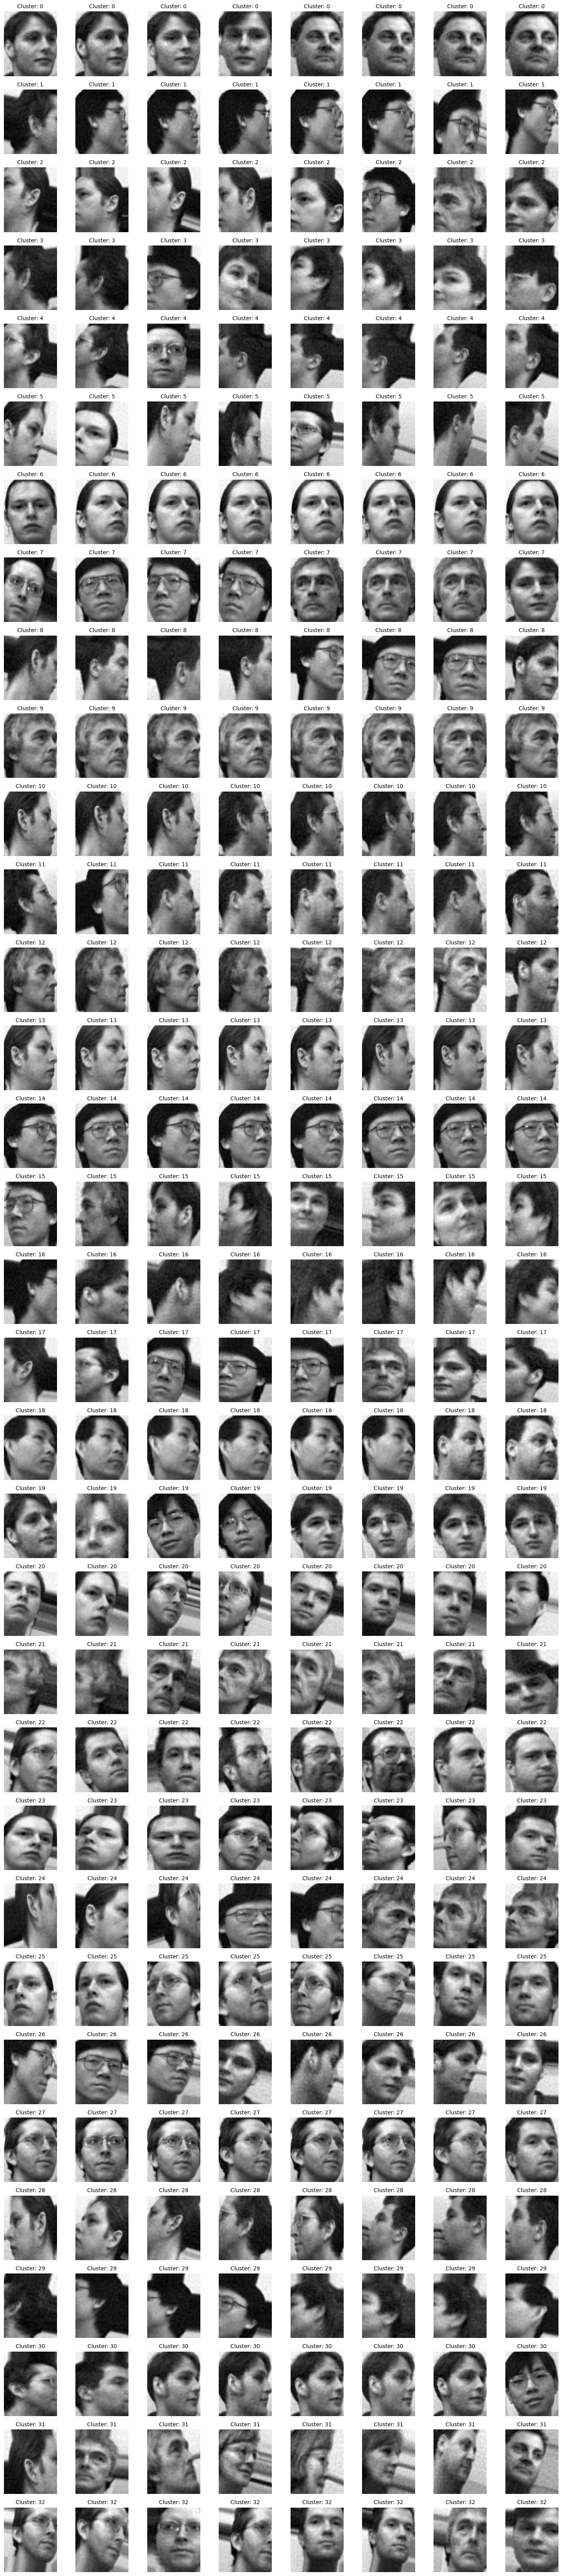

In [26]:
X_train_reconstructed = pca.inverse_transform(X_train_pca)


y_kmeans_unique = np.unique(y_kmeans)
plt.figure(figsize=(15, len(y_kmeans_unique) * 2))  # Adjust the figure size as needed

for i, cluster in enumerate(y_kmeans_unique):
    indices = np.where(y_kmeans == cluster)[0]
    for j, index in enumerate(indices):
        if j >= 8:  # Limit to 8 images per cluster for better visualization
            break
        plt.subplot(len(y_kmeans_unique), 8, i * 8 + j + 1)
        plt.imshow(np.reshape(X_train_reconstructed[index], (112, 92)), cmap=plt.cm.gray)
        plt.title('Cluster: ' + str(cluster), fontsize=10)
        plt.axis('off')

plt.tight_layout()
plt.show()


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

# Combine PCA-reduced features with K-Means cluster assignments
# Ensure consistent one-hot encoding for cluster labels
num_clusters = len(np.unique(y_kmeans))  # Number of clusters from KMeans
clusters_one_hot = to_categorical(y_kmeans, num_clusters)
# Augment datasets with one-hot encoded clusters
X_train_augmented = np.hstack((X_train_pca, clusters_one_hot))
X_val_clusters = to_categorical(kmeans.predict(X_val_pca), num_clusters)
X_val_augmented = np.hstack((X_val_pca, X_val_clusters))
X_test_clusters = to_categorical(kmeans.predict(X_test_pca), num_clusters)
X_test_augmented = np.hstack((X_test_pca, X_test_clusters))

# Debugging: Check augmented dataset shapes
print("Augmented Shapes:", X_train_augmented.shape, X_val_augmented.shape, X_test_augmented.shape)

Augmented Shapes: (960, 451) (113, 451) (113, 451)


In [29]:
# One-hot encode labels for classification
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)
y_test_one_hot = to_categorical(y_test)

In [ ]:
# Check the shape of X_train_augmented
input_shape = X_train_augmented.shape[1]

# Build the neural network
model = Sequential([
    Dense(256, activation='relu', input_shape=(input_shape,), kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(y_train_one_hot.shape[1], activation='softmax')
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train_augmented, y_train_one_hot,
    validation_data=(X_val_augmented, y_val_one_hot),
    epochs=50,
    batch_size=32
)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0520 - loss: 8.4366 - val_accuracy: 0.4071 - val_loss: 6.5332
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1615 - loss: 6.6876 - val_accuracy: 0.6283 - val_loss: 5.4585
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2468 - loss: 5.7213 - val_accuracy: 0.7522 - val_loss: 4.5065
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3467 - loss: 4.8764 - val_accuracy: 0.8142 - val_loss: 3.7384
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3932 - loss: 4.3169 - val_accuracy: 0.8496 - val_loss: 3.1251
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4789 - loss: 3.8015 - val_accuracy: 0.8938 - val_loss: 2.7037
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4528 - loss: 3.5744 - val_accuracy: 0.8761 - val_loss: 2.3743
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5516 - loss: 3.1450 - val_accuracy: 0.8938 - val_loss

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9913 - loss: 0.6106 
Test Loss: 0.6085025668144226
Test Accuracy: 0.991150438785553


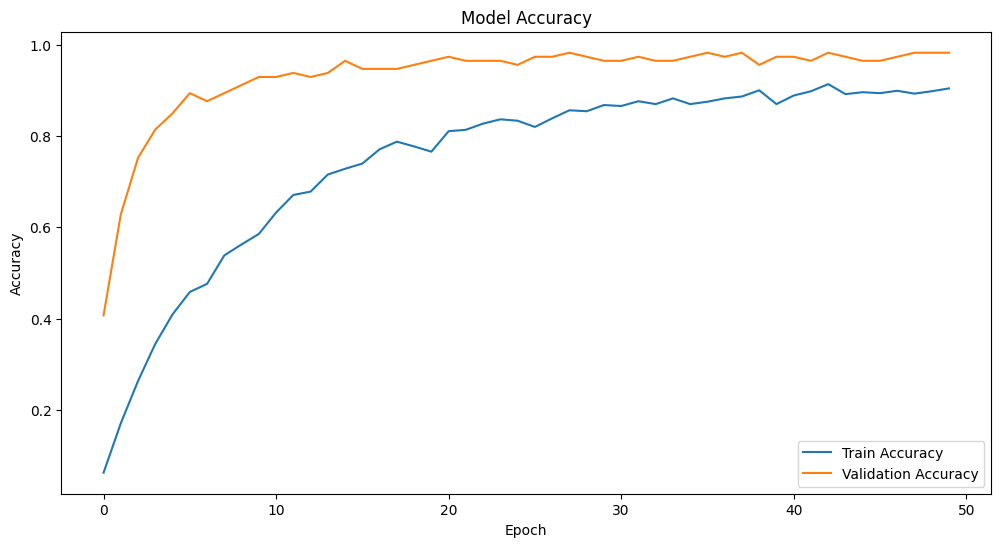

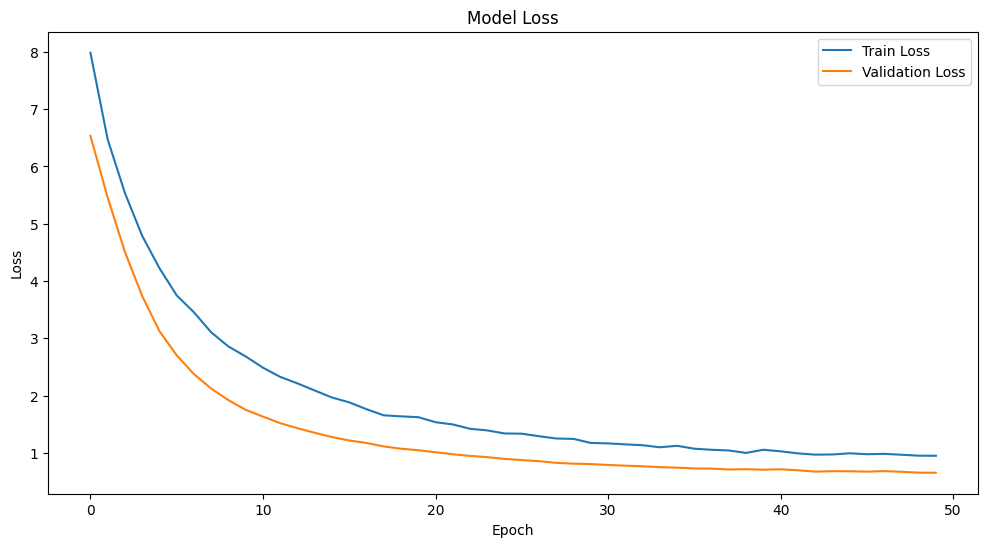

In [ ]:
# Evaluate the model
results = model.evaluate(X_test_augmented, y_test_one_hot)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


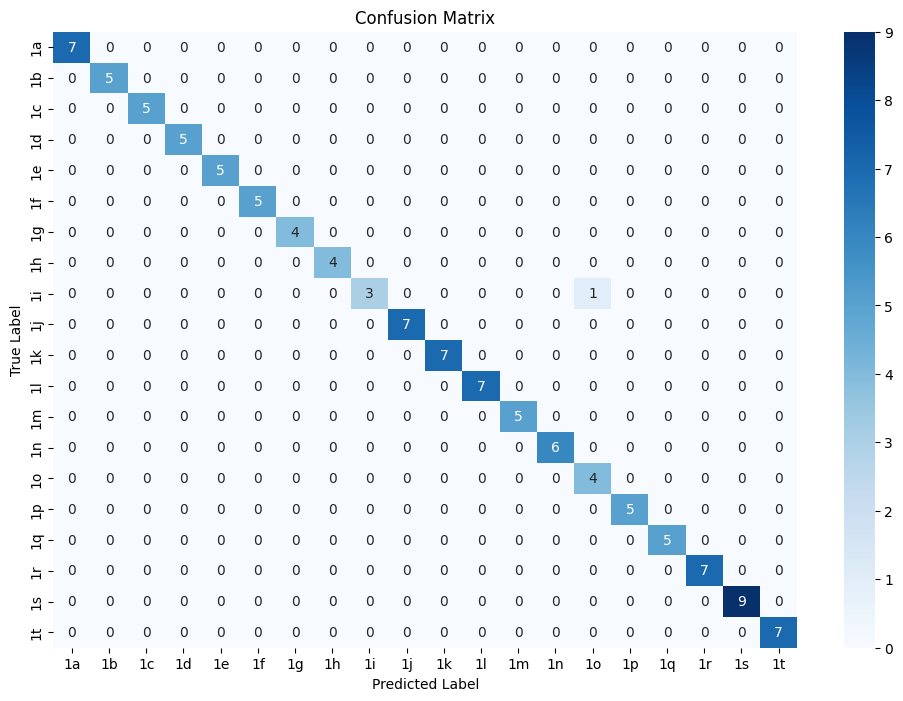

In [ ]:
# Predictions
y_pred = model.predict(X_test_augmented)
y_pred = np.argmax(y_pred, axis=1)

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


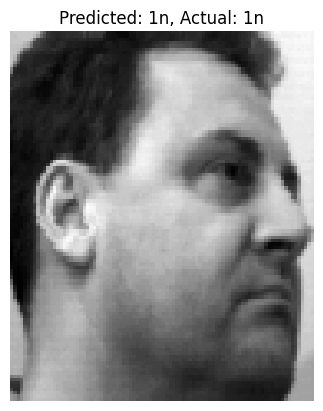

In [ ]:
# Lets try it with images to see how well it works
# Select a random test image
random_index = np.random.randint(0, X_test.shape[0])
random_image = X_test[random_index]

# Reshape the image to (1, 112, 92) to match the model input dimensions
random_image = random_image.reshape(1, -1)

# Perform PCA on the image
random_image_pca = pca.transform(random_image)

# Perform KMeans clustering on the PCA features
random_image_cluster = kmeans.predict(random_image_pca)

# One-hot encode the cluster
random_image_cluster_one_hot = to_categorical(random_image_cluster, num_clusters)

# Combine PCA features with cluster assignment
random_image_augmented = np.hstack((random_image_pca, random_image_cluster_one_hot))

# Make a prediction
prediction = model.predict(random_image_augmented)
predicted_label = np.argmax(prediction)
actual_label = y_test[random_index]

# Display the image and prediction and actual label
plt.imshow(np.reshape(random_image, (112, 92)), cmap='gray')
plt.title(f'Predicted: {le.inverse_transform([predicted_label])[0]}, Actual: {le.inverse_transform([actual_label])[0]}')
plt.axis('off')
plt.show()
